In [1]:
import numpy as np
import tensorflow as tf
from models import get_actor
from functools import partial
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from matplotlib.ticker import MaxNLocator
import pandas as pd

import sys
from pathlib import Path
sys.path.append(Path(sys.path[0]).parent.parent.as_posix())
from environments.custom_acrobot import CustomAcrobot

%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/gustavo/miniconda3/lib/python3.10/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/gustavo/miniconda3/lib/python3.10/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV22Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [2]:
def terminal_func(theta1_expected, theta2_expected, var, state):
    return all((
        np.abs(state[0] - theta1_expected) < var,
        np.abs(state[1] - theta2_expected) < var,
        # np.abs(state[2]) < .25,
        # np.abs(state[3]) < .25,
    ))

def analyze(path, states, max_steps):
    model = get_actor(6)
    model.load_weights(path / "actor_main.h5")

    env = CustomAcrobot.from_file(path / "env.pickle")

    steps_until_done = []

    for s in tqdm(states):
        env.state = np.array([np.arccos(s[0]), np.arccos(s[2]), s[4], s[5]])
        state = s
        for i in range(max_steps):
            action = model(tf.expand_dims(state, 0))
            state, _, done, *_ = env.step(action)
            if done:
                break

        steps_until_done.append(i + 1)

    return steps_until_done


In [3]:
path = Path("run_20230307_161707")

In [4]:
states = pd.read_csv("states.csv", dtype=np.float32).to_numpy()
states.shape

(15, 6)

In [29]:
results = analyze(path, states, 10_000)

np.mean(results), np.std(results)

/Users/gustavo/miniconda3/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


(2129.133333333333, 3937.9114069375514)

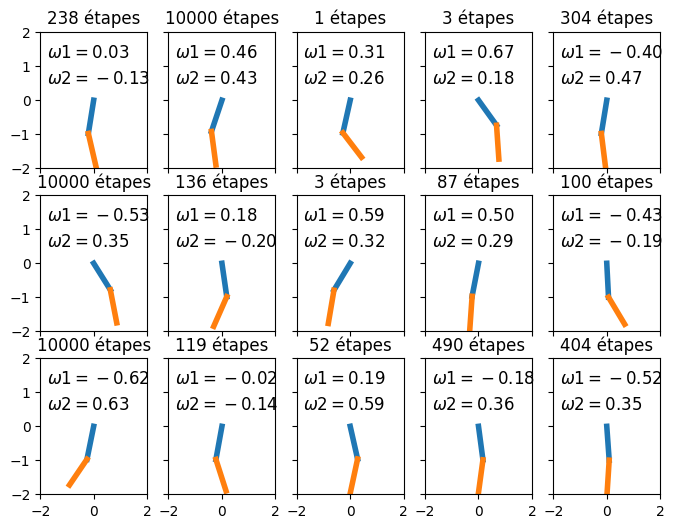

In [31]:
x0 = y0 = 0
n_rows = 3
n_cols = 5
fig, axss = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(8, 6))
for i, axs in enumerate(axss):
    for j, ax in enumerate(axs):
        idx = i * n_cols + j
        x1 = states[idx, 1]
        y1 = -states[idx, 0]

        x2 = x1 + states[idx, 3]
        y2 = y1 - states[idx, 2]

        ax.plot([x0, x1], [y0, y1], linewidth=4)
        ax.plot([x1, x2], [y1, y2], linewidth=4)
        ax.annotate(rf"$\omega1={states[idx, 4]:.2f}$", (-1.75, 1.25), fontsize=12)
        ax.annotate(rf"$\omega2={states[idx, 5]:.2f}$", (-1.75, .5), fontsize=12)
        ax.set_title(f"{results[idx]} étapes", fontsize=12)

        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)


In [7]:
"""
df = pd.DataFrame(states, columns=["cos(theta1)", "sin(theta1)", "cos(theta2)", "sin(theta2)", "omega1", "omega2"])
df.to_csv("states.csv", index=False)

rng = np.random.default_rng(42)
seeds = rng.integers(1, 1_000, 15)
states = [
    env.reset(seed=int(seed), options={
        'low': -np.pi / 4,
        'high': np.pi / 4
    })[0] for seed in seeds
]
"""

'\ndf = pd.DataFrame(states, columns=["cos(theta1)", "sin(theta1)", "cos(theta2)", "sin(theta2)", "omega1", "omega2"])\ndf.to_csv("states.csv", index=False)\n\nrng = np.random.default_rng(42)\nseeds = rng.integers(1, 1_000, 15)\nstates = [\n    env.reset(seed=int(seed), options={\n        \'low\': -np.pi / 4,\n        \'high\': np.pi / 4\n    })[0] for seed in seeds\n]\n'